In [26]:
import numpy as np
from empiricaldist import Pmf
import pandas as pd
from scipy.stats import norm, binom

In [3]:
# estimate the number of locomotive
def estimate_count(prior, data):
    hypos = prior.qs
    posterior = prior.copy()
    for x in data:
        likelihood = 1.0 / hypos
        # impossible for count to be less than the data
        likelihood[hypos < x] = 0
        posterior *= likelihood
    posterior.normalize()
    return posterior.mean()

# attempt 1: uniform prior
prior = Pmf(1, np.arange(1, 1000))
estimate_count(prior, [60])

333.18362350273196

In [4]:
# show it's sensitive to prior
(estimate_count(Pmf(1, np.arange(1, 500)), [60]),
 estimate_count(Pmf(1, np.arange(1, 1000)), [60]),
 estimate_count(Pmf(1, np.arange(1, 2000)), [60]))

(206.80387729525884, 333.18362350273196, 551.973048566268)

In [5]:
# solution 1: collect more data
(estimate_count(Pmf(1, np.arange(1, 500)), [60, 90, 30]),
 estimate_count(Pmf(1, np.arange(1, 1000)), [60, 90, 30]),
 estimate_count(Pmf(1, np.arange(1, 2000)), [60, 90, 30]))

(151.80348606277954, 164.29208953758175, 171.33451161537945)

<Axes: >

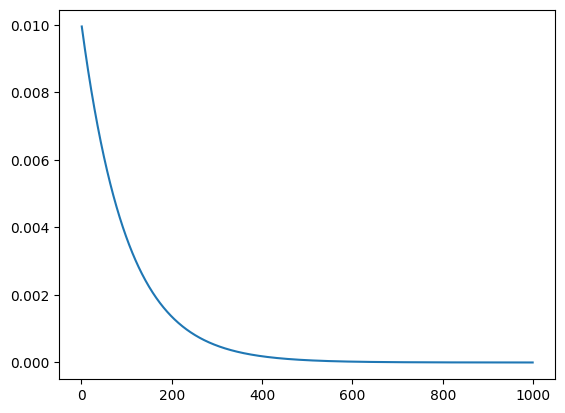

In [21]:
# solution 2: choose a better prior (power law)
def power_law_prior(n, alpha=0.01):
    ps = np.exp(-np.arange(1,n) * alpha)
    prior = Pmf(ps, np.arange(1, n))
    prior.normalize()
    return prior

power_law_prior(1000).plot()

In [22]:
(estimate_count(power_law_prior(500), [60]),
 estimate_count(power_law_prior(1000), [60]),
 estimate_count(power_law_prior(2000), [60]))

(118.99670225109685, 120.16378989959166, 120.17263635321657)

In [23]:
(estimate_count(power_law_prior(1000, 0.001), [60]),
 estimate_count(power_law_prior(1000, 0.01), [60]),
 estimate_count(power_law_prior(1000, 0.1), [60]))

(275.56598764673805, 120.16378989959166, 68.34111360559169)

In [ ]:
# but it's still sensitive to the choice of alpha.

In [24]:
power = power_law_prior(1000)
power.quantile([0.5]) # 50% percentile

array([70.])

In [25]:
power.credible_interval(0.9)

array([  6., 300.])

In [32]:
# exercise 1: estimate number of people in a hall
def estimate_people_in_a_hall(prior, counts):
    hypos = prior.qs
    posterior = prior.copy()
    n_days = 365
    for x in counts:
        likelihood = binom.pmf(x, hypos, 1 / n_days)
        posterior *= likelihood
        n_days -= 1
    posterior.normalize()
    return posterior.mean()

print(estimate_people_in_a_hall(Pmf(1, np.arange(200, 2000)), [2, 1, 0]))

# see if it's sensitive to prior
print(estimate_people_in_a_hall(Pmf(1, np.arange(100, 1000)), [2, 1, 0]))
print(estimate_people_in_a_hall(Pmf(1, np.arange(300, 1000)), [2, 1, 0]))
print(estimate_people_in_a_hall(Pmf(1, np.arange(300, 5000)), [2, 1, 0]))
print(estimate_people_in_a_hall(Pmf(1, np.arange(500, 5000)), [2, 1, 0]))

516.0237221673526
463.52652785187956
538.6191905336282
568.1488246614252
715.2883347882264


,probs
0,10


4    0.325156
5    0.221973
6    0.160571
7    0.121341
8    0.094837
9    0.076122
dtype: float64
5.667097866874025


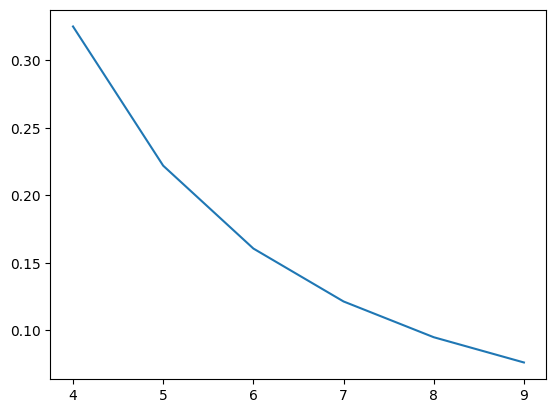

In [42]:
# estimate rabbit count problem

def estimate_rabbit(min_count, max_count, n_taken, n_same):
    hypos = np.arange(min_count, max_count)
    prior = Pmf(1, hypos)
    posterior = prior.copy()
    probability_of_seeing_any_one = (1.0 / hypos)
    likelihood = binom.pmf(n_same, n_taken, probability_of_seeing_any_one) # this may be wrong?
    posterior *= likelihood
    posterior.normalize()
    return posterior

est = estimate_rabbit(4, 10, 3, 2)
print(est)
est.plot()
print(est.mean())

In [44]:
# prisoner problem
ps = [1/6.0, 2/6.0, 3/6.0] 
qs = [1, 2, 3]
pmf = Pmf(ps, qs)
pmf.mean() # average sentence

2.333333333333333

In [69]:
# US sibling problem
hypos = np.arange(0.1, 1.0, 0.01)
prior = Pmf(1, hypos)

def update_us_sibling(prior, data):
    hypos = prior.qs.copy()
    posterior = prior.copy()
    for group in data:
        sib4, sib3, sib2, sib1 = group
        likelihood  = 4 * sib4 * hypos
        likelihood += 3 * sib3 * hypos
        likelihood += 2 * sib2 * hypos
        likelihood += 1 * sib1 * hypos
        posterior *= likelihood
    posterior.normalize()
    return posterior

posterior = update_us_sibling(prior, [
    [40, 25, 24, 11], # '76 data
    [13, 23, 43, 21], # '94 data
    [14, 24, 41, 22]  # '14 data
])

0.9899999999999995
0.7960327287532178


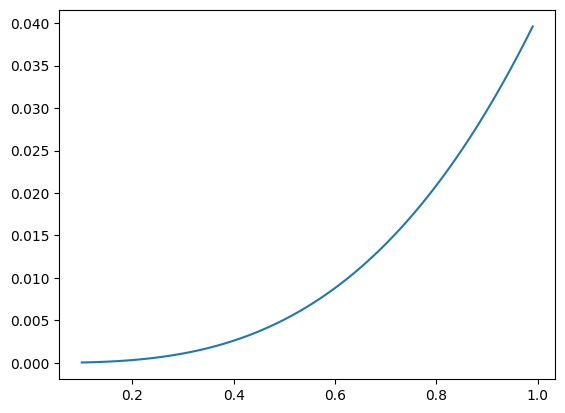

In [70]:
posterior.plot()
print(posterior.max_prob())
print(posterior.mean())

2
2.6982758620689653


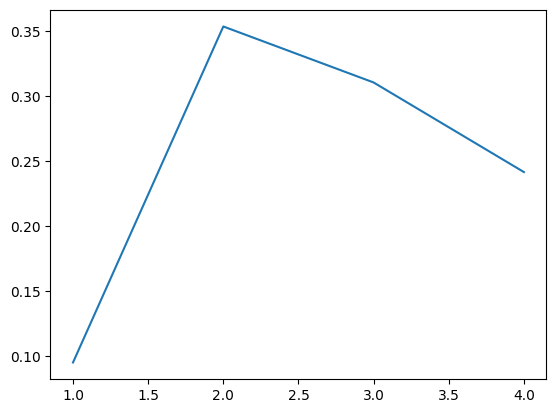

In [74]:
# the above analysis is plain wrong. The likelihood makes no sense.

qs = np.arange(1, 5)
ps = np.array([22, 41, 24, 14])
prior = Pmf(ps, qs)
prior.normalize()

def update_us_sibiling(prior):
    hypos = prior.qs.copy()
    posterior = prior.copy()
    likelihood = [1, 2, 3, 4]
    posterior *= likelihood
    posterior.normalize()
    return posterior

posterior = update_us_sibiling(prior)
posterior.plot()
print(posterior.max_prob())
print(posterior.mean()) # average number of siblings (including self) if you ask a random person

In [80]:
posterior[posterior.qs > 1.0].sum()

0.9051724137931034

In [82]:
# dooms day problem
qs = [200, 2000]
prior = Pmf(1, qs)
posterior = prior.copy()
likelihood = 108/200, 108/2000
posterior *= likelihood
posterior.normalize()
posterior

,probs
200,0.909091
2000,0.090909


In [83]:
# so from this analysis we are 90% likely to live in the short-lived civilization
# now let's calculate the expected lifespan of human civilization

qs = np.arange(140, 2000)
prior = Pmf(1, qs)
likelihood = 1 / qs
posterior = prior * likelihood
posterior.normalize()
posterior.mean()

698.5690648567195

In [ ]:
# with an arbitrary prior and a single data point, we get the result that humanity continue till about 700B total births.